# Probabilistic and statistical analysis of the coin toss problem
One of the simplest problem in mechanics is the mass-spring system. The Newton equation is easily solvable using ordinary differential equation techniques. When I was doing by bachelor in physics, one of my professor insisted that we always start with the easiest system and analyse it from every angle. In quantum mechanics, we studied the harmonic oscillator (which is just a fancy and general name for a mass-spring system). During my bachelor and the beginning of my master, I solve it at least five different ways.  I've thus decided to apply the lesson of this particular teacher when doing a career path change to the field of data science. Since I have not applied probabilistic and statistical analysis for a long time, I thought that the coin toss problem was the way to refresh my memory.

## 1. Bayesian approch and MCMC

This first section is base on the code of [Probabilistic Programming & Bayesian Methods for Hackers](https://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/#contents). We will see how to calculate the probability of the parameter p of the coin toss givin the observed data.


In [1]:
import numpy as np
import pymc as pm

We will use the uniform prior with it's Beta function representation. That is with alpha = beta = 1. We use the Beta function since it it the conjugate prior to the bernouilli random function. 

In [2]:
# The parameters are the bounds of the Uniform.
p = pm.Beta('p',alpha=1,beta=1)

### Experiment simulation

In [3]:
# set constants
p_true = 0.05  # remember, this is unknown.
N = 1500

# Data generation
occurrences = pm.rbernoulli(p_true, N)
k = occurrences.sum()

In [4]:
# Occurrences.mean is equal to n/N.
print("What is the observed frequency? %.4f" % occurrences.mean())
print("Does this equal the true frequency? %s" % (occurrences.mean() == p_true))

What is the observed frequency? 0.0540
Does this equal the true frequency? False


### Monte carlo calculation for estimation of the posterior

In [5]:
# include the observations, which are Bernoulli
obs = pm.Bernoulli("obs", p, value=occurrences, observed=True)

# To be explained in chapter 3
mcmc = pm.MCMC([p, obs])
mcmc.sample(18000, 1000)

 [-----------------100%-----------------] 18000 of 18000 complete in 1.2 sec

In [6]:
from math import lgamma,exp,log

### Exact posterior calculation

The exact posterior can be represented with the beta function. Because the gamma function grows rapidly, we use the log-gamma to do the calculation and then do the exponential at the end. 

In [7]:
a = 1.0 # for uniform prior
b = 1.0 # for uniform prior
x = np.linspace(0.03,0.07,100)

prefactor_log = lgamma(N+a+b) - lgamma(a+k) - lgamma(N+b-k)
factor1_log = (k+a-1)*np.log(x) 
factor2_log = (N-k+b-1)*np.log(1-x)

exact_posterior = np.exp( np.repeat(prefactor_log,100 )+  factor1_log + factor2_log)

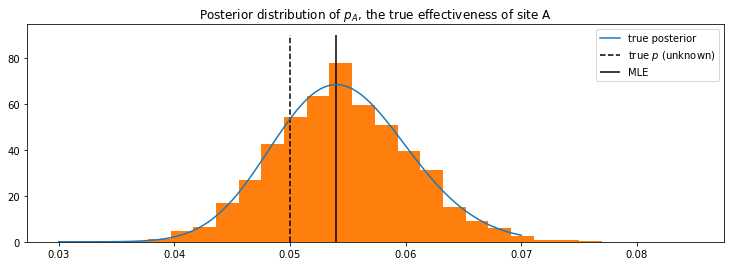

In [8]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt

figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p$ (unknown)")
plt.vlines(k/N, 0, 90, linestyle="-", label="MLE")
plt.plot(x, exact_posterior,  label="true posterior")
plt.hist(mcmc.trace("p")[:], bins=25, histtype="stepfilled", normed=True)
plt.legend();

## 2. Statistics

## Normal estimate

The first method to calculate the confidence in a parameter is to suppose that the mean follow the normal distribution. We thus need to estimate its variance with the bootstap method. The usual usage of the normal estimate is to calculate a confidence interval but I wanted to compare the results with the one obtained with the bayesian approach. The justification for the following section are in  [All of Statistics: A Concise Course in Statistical Inference](https://www.amazon.ca/All-Statistics-Concise-Statistical-Inference/dp/0387402721/ref=sr_1_1?ie=UTF8&qid=1472153873&sr=8-1&keywords=Larry+Wasserman%2C+All+of+Statistics+%3A+A+Concise+Course+in+Statistical+Inference)

In [9]:
import numpy as np

number_of_samples = 10000
number_per_sample = occurrences.shape[0]
original_sample = occurrences*1.0

indexes = np.random.randint(0,occurrences.shape[0], size=(number_of_samples, number_per_sample))

In [10]:
random_samples = original_sample[indexes]

In [11]:
means_of_random_samples = np.mean(random_samples,axis=1) 
bootstrap_variance = np.var(means_of_random_samples)
standard_error_bootstrap = np.sqrt(bootstrap_variance)

In [12]:
maximum_likelihood_estimate = k/N

In [13]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))/np.sqrt(2*np.pi*sig**2)

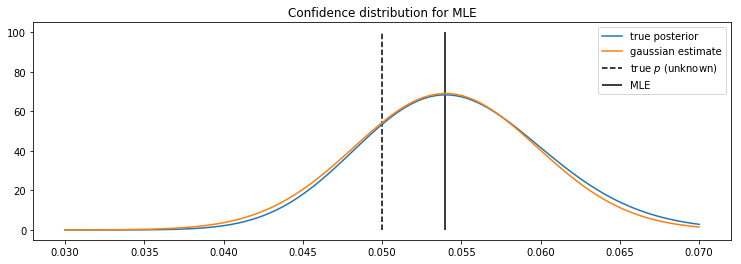

In [14]:
figsize(12.5, 4)

plt.title("Confidence distribution for MLE")
plt.vlines(p_true, 0, 100, linestyle="--", label="true $p$ (unknown)")
plt.vlines(k/N, 0, 100, linestyle="-", label="MLE")
plt.plot(x, exact_posterior,  label="true posterior")
plt.plot(x,gaussian(x, maximum_likelihood_estimate, standard_error_bootstrap), label="gaussian estimate")
plt.legend();

## Percentile confidence interval

The second method to calculate the confidance in the parameter is to calculate estimate the distribution of the parameter using the bootstrap method. For the implementation, we will use the percentile method of numpy. Otherwise, we would need to calcule the cumulative distribution and then reverse it to find the corresponding values for the upper and lower bound. 

In [15]:
indexes = np.random.randint(0,occurrences.shape[0], size=(number_of_samples, number_per_sample))
random_samples = original_sample[indexes]
means_of_random_samples = np.mean(random_samples,axis=1)

alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(means_of_random_samples, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(means_of_random_samples, p))
print('%.1f confidence interval %.4f and %.4f' % (alpha*100, lower, upper))

95.0 confidence interval 0.0427 and 0.0660


## p-value calculation

Suppose that we have have a sample of 30 coin flip and that 22 are heads. We want to test the hypothesis of a fair coin. We will do a quick simulation to calculate the p-value. The p_value is the probability of obtaining the obtained result or a more extreme value. This exemple is given is the lecture [Statistics for Hackers](https://www.youtube.com/watch?v=Iq9DzN6mvYA) by Jake Vanderplas.

In [16]:
from scipy.stats import binom
import pymc as pm
import timeit

### Simulation method

p_value_simulation = 0
number_of_simulations = 1000000
test_value = 22
sample_size = 30
probability_of_head = 0.5



for i in range(number_of_simulations):

    occurrences = pm.rbernoulli(probability_of_head, sample_size)
    sum_coin_tosses = occurrences.sum()

    if sum_coin_tosses >= test_value:
        p_value_simulation += 1
 
p_value_simulation /= number_of_simulations

### Probabilistic method

probability_of_less_than_value = binom.cdf(test_value-1, sample_size, probability_of_head)
p_value_calculated = 1 - probability_of_less_than_value

 

In [17]:
print("Calculated p-value: {0}".format(p_value_calculated))
print("Simulation p-value: {0}".format(p_value_simulation))    

Calculated p-value: 0.008062400855123997
Simulation p-value: 0.008071


the problem with the previous method is that we use a for loop, which is slow in python, to calculate the p-value. The following cells show how to vectorize the function and how much calculation time can be saved using the numpy library.

In [18]:
from numpy.random import randint
import time

def p_value_method_1():
    
    p_value_simulation = 0
    number_of_simulations = 1000000
    test_value = 22
    sample_size = 30
    probability_of_head = 0.5

    for i in range(number_of_simulations):

        occurrences = pm.rbernoulli(probability_of_head, sample_size)
        sum_coin_tosses = occurrences.sum()

        if sum_coin_tosses >= test_value:
            p_value_simulation += 1
    
    p_value_simulation /= number_of_simulations
    
    return p_value_simulation

def p_value_method_2():
    
    number_of_simulations = 1000000
    test_value = 22
    sample_size = 30

    
    simulation_values = randint(0,2, size=(number_of_simulations, sample_size))
    simulation_values_sums = np.sum(simulation_values, axis=1)
    simulation_values_sums_valid = (simulation_values_sums >= test_value)
    p_value = simulation_values_sums_valid.mean()
    
    return p_value


In [19]:
%%timeit
p_value_method_1()

1 loop, best of 3: 5.64 s per loop


In [20]:
%%timeit
p_value_method_2()

10 loops, best of 3: 178 ms per loop
